In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import numpy as np
import math
from matplotlib.collections import PatchCollection

## Episodes learning

In [67]:
#plt.style.available
plt.style.use('ggplot')

def plot_episode(num_birds=2):
    df = pd.read_csv("data/episode.csv")
    df["NormEndTime"] = df["EndTime"] / 1000
    df["mean_norm_end"] = df["NormEndTime"] .rolling(100, min_periods=5).mean()
    #print(df)
    pred_train = df["PredatorTraining"]
    learner_change = np.where(np.roll(pred_train, -1) != pred_train)[0]
    ax = df.plot(x="Episode", y="mean_norm_end", kind="line", lw=0.5, legend=False, figsize=(16,9))
    ax.set_ylabel("EndTime")
    for i, x_l in enumerate(learner_change):
        if i%num_birds == 0:
            ax.axvline(x=x_l, color="red", linestyle='--', lw=1)
        else:
            ax.axvline(x=x_l, color="blue", linestyle='--', lw=1)

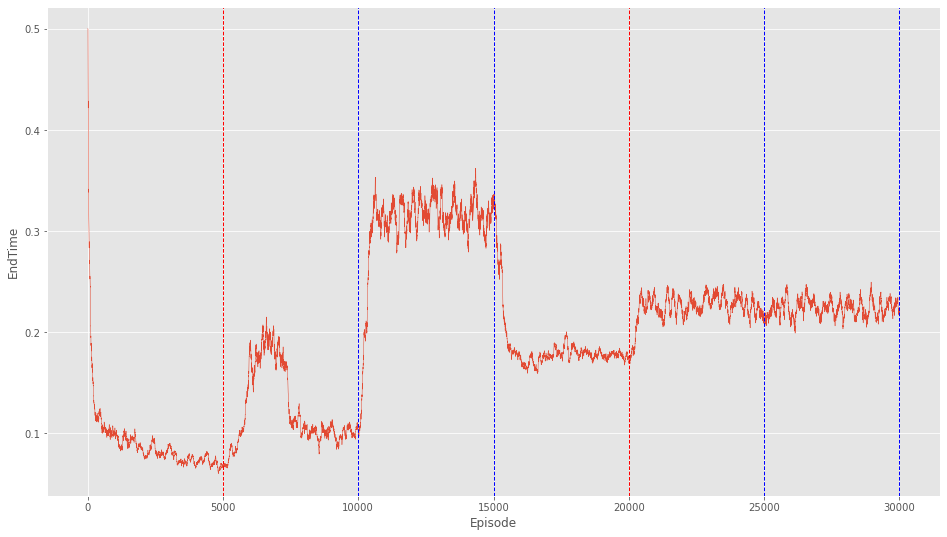

In [68]:
plot_episode(3)

## New processing

In [47]:
#TODO: needs to be fixed now

def plot_policy(csv_file, episode):
    
    fig, ax = plt.subplots()
    sec_num = 6
    patches = []
    
    points = ax.scatter(x, y, color="darkblue", s=5)
    points = [plt.scatter([], [], color="darkblue", s=5) for i in range(6)]
    # add the vision cone
    wedge = mpatches.Wedge((1, 1), 2, 0, 180, alpha=0.2, lw=1.5)
    patches.append(wedge)

    x = [2*math.cos(-math.pi/(sec_num-1)*i)+1 for i in range(1,sec_num-1)]
    y = [2*math.sin(math.pi/(sec_num-1)*i)+1 for i in range(1,sec_num-1)]

    for i in range(sec_num-2):
        ax.plot([1,x[i]],[1,y[i]], color="cornflowerblue", lw=0.3)
    
    t_p = np.array([[0,0], [1/2,math.sqrt(3)/2], [1,0]])*1/2  + np.array([3/4,1/2])
    
    # Simplex outside sectors
    t = mpatches.Polygon(t_p, alpha=0.2, lw=2)
    patches.append(t)
    
    t_coord = []
    
    for i in range(1,6):
        n_shift = 1.5*np.array([-math.cos(-i*math.pi/sec_num), math.sin(i*math.pi/sec_num)])
        t_coord.append(t_p + n_shift)
        t = mpatches.Polygon(t_coord[i-1], alpha=0.2, lw=2)
        patches.append(t)

    #print(t_coord)
    
    #Data preparation
    df = preprocessing(5000,32)
    df = extract_policy(df, ["Left_p", "Straight_p", "Right_p"])
    x = (df[("Left_p",)] - df[("Right_p",)])/2 + 0.5
    y = df[("Straight_p",)]
    sectors = [0,1,2,4,8,16]
    
    def animate(i):
        sec_num = len(df)
        s_point = t_p[0] + np.array([x[0][i]/2, y[0][i]/2])
        points[0].set_sizes([s_point[0], s_point[1]])
        
        for k in sectors[1:]:
            s_point = t_coord[k-1] + np.array([x[6-k][i]/2, dy[6-k][i]/2])
            points[k].set_sizes([s_point[0][0], s_point[0][1]])

            
    animate(episode)
    collection = PatchCollection(patches, match_original=True)
    ax.add_collection(collection)
    for p in points:
        ax.add_collection(p)
    plt.axis('equal')
    plt.axis('off')
    plt.tight_layout()

    plt.show()

In [71]:
def preprocessing():
    df = pd.read_csv("data/value_policy.csv")
    df_aux = pd.read_csv("data/episode.csv")
    episodes = len(df_aux)
    states = len(df)//episodes
    df["State"] = [ i%states for i in range(episodes*states)]
    df["Episode"] = [i//states for i in range(episodes*states)]
    index = ['Episode', 'State']
    df.set_index(index, inplace=True)
    df = df.loc[(slice(None),[0,1,2,4,8,16]),:]
    return df

def softmax(a):
    a = a - np.mean(a, axis=1, keepdims=True)
    a = np.exp(a)
    return a / np.sum(a, axis=1, keepdims=True)

#Extract policy
def extract_policy(df, cols):
    d = df[cols]
    d = d.unstack("State")
    #Softmax
    m = d.mean(axis=1, level=1)
    d = d.subtract(m,axis=0)
    d = d.apply(np.exp)
    s = d.sum(axis=1, level=1)
    d = d.divide(s,axis=0)
    return d

def extract_value(df, col):
    d = df[col]
    d = d.unstack("State")
    return d

<AxesSubplot:xlabel='Episode'>

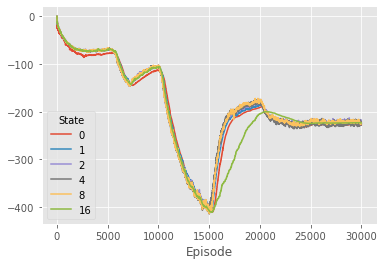

In [72]:
df = preprocessing()
df = extract_value(df, "value_0")
df.plot()

<AxesSubplot:xlabel='Episode'>

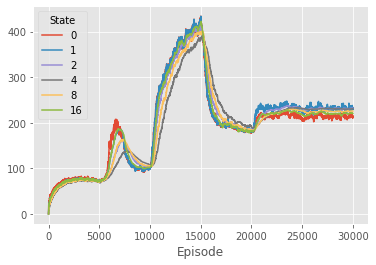

In [73]:
df = preprocessing()
df = extract_value(df, "value_1")
df.plot()

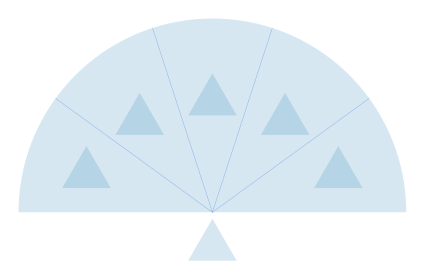

In [49]:
plot_policy("policy_pursuer.csv",2000)
#df = pd.read_csv("policy_pursuer.csv")
#df

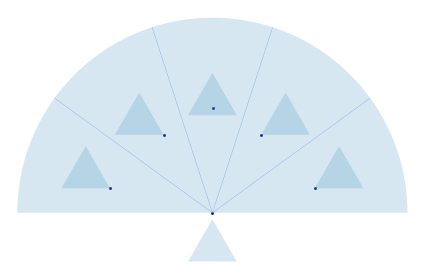

In [106]:
plot_policy("policy_evader.csv")

In [15]:
episodes_num = 5000
states_num = 2**5-1
index = ['Episode', 'State']
df = pd.read_csv("policy_pursuer.csv")
#Keep 0, 1, 4, 8, 16
df.set_index(index, inplace=True)
df = df.loc[(slice(None),[0,1,2,4,8,16]),:]

In [16]:
df.loc[(10,slice(None)),]

Left  Straight     Right
Episode State                              
10      0     -0.212696 -0.236084 -0.209639
        1      0.049977  0.071204  0.081663
        2      0.081510  0.081365  0.076343
        4      0.074778  0.075746  0.075361
        8      0.071842  0.072421  0.073751
        16     0.070051  0.072689  0.047011

<AxesSubplot:>

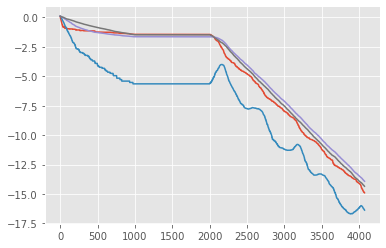

In [89]:
df.loc[(slice(None),0),"Left"].plot(use_index=False)
df.loc[(slice(None),1),"Left"].plot(use_index=False)
df.loc[(slice(None),2),"Left"].plot(use_index=False)
df.loc[(slice(None),4),"Left"].plot(use_index=False)

In [86]:
episodes_num = 5000
states_num = 2**5-1
index = ['Episode', 'State']
df = pd.read_csv("value_pursuer.csv")
#Keep 0, 1, 4, 8, 16
df.set_index(index, inplace=True)
df = df.loc[(slice(None),[0,1,2,4,8,16]),:]

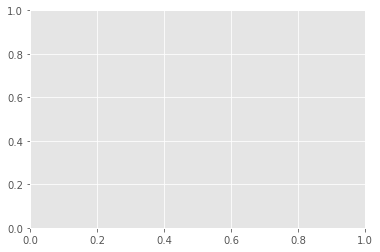

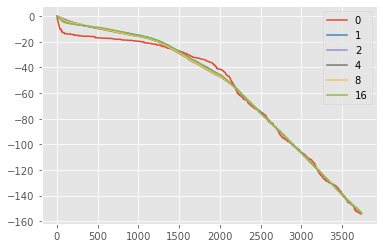

In [87]:
fig, ax = plt.subplots()
ax = df.loc[(slice(None),0),].plot(use_index=False)
df.loc[(slice(None),1),].plot(use_index=False, ax=ax)
df.loc[(slice(None),2),].plot(use_index=False, ax=ax)
df.loc[(slice(None),4),].plot(use_index=False, ax=ax)
df.loc[(slice(None),8),].plot(use_index=False, ax=ax)
df.loc[(slice(None),16),].plot(use_index=False, ax=ax)
ax.legend([0,1,2,4,8,16])

In [13]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

In [39]:
## Old processing

In [ ]:
plt.style.use('fivethirtyeight')
df = pd.read_csv("policy.csv")
df_actual = df[df["Straight"]!=0.1]
s = df_actual.sum(axis=1)
df_actual = df_actual.divide(s, axis="index")
#df_actual

#Isometric projection
df_actual["Left"] = df_actual["Left"]*math.sqrt(3)/2
df_actual["Right"] = df_actual["Right"]*math.sqrt(3)/2
#m = df_actual.min(axis=1)
#df_actual = df_actual.subtract(m, axis="index")
df_actual["dx"] = df_actual["Right"] - df_actual["Left"]
df_actual["dy"] = df_actual["Straight"]
df = df_actual
df.reset_index(drop=True, inplace=True)
df

In [ ]:
fig, ax = plt.subplots()
patches = []

# add a wedge
wedge = mpatches.Wedge((1, 1), 2, 0, 180, color="white", ec="black")
patches.append(wedge)

x = [2*math.cos(-math.pi/5*i)+1 for i in range(1,5)]
y = [2*math.sin(math.pi/5*i)+1 for i in range(1,5)]

for i in range(4):
    ax.plot([1,x[i]],[1,y[i]], color="black")

# add an arrow
arrow = mpatches.Arrow(1, 0, df["dx"][0], df["dy"][0], width=0.05, color="black")
patches.append(arrow)
    
for i in range(1,len(df_actual)):
    arrow = mpatches.Arrow((i-1)*0.5, 1.3 + 0.5*math.sin(math.pi/4*(i-1)), 
                           df["dx"][6-i], df["dy"][6-i], width=0.05, color="black")
    patches.append(arrow)

collection = PatchCollection(patches, match_original=True)
ax.add_collection(collection)
plt.axis('equal')
plt.axis('off')
#ax.plot([] , 'bo')
plt.tight_layout()

plt.show()